In [1]:
%matplotlib inline

import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

In [2]:
# %load -r 8-16,29-42,51-73 lstm_beat_tracking.py
import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, TimeDistributed, Dense, Activation, Dropout
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    _precision = true_positives / (predicted_positives + K.epsilon())
    return _precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    _recall = true_positives / (possible_positives + K.epsilon())
    return _recall

def create_dataset(trainX, trainY, n_of_frames, look_back, diff_halfwave=False):
    total_frames, n_of_freq_bins = trainX.shape

    if diff_halfwave:
        trainX = np.diff(trainX, axis=0)
        trainX = np.concatenate((trainX[:1, :], trainX), axis=0)
        trainX = np.maximum(np.zeros(trainX.shape), trainX)
        scaler = MinMaxScaler(feature_range=(0, 1))
        trainX = scaler.fit_transform(trainX)

    _trainX, _trainY = [], []
    for s in range(total_frames // n_of_frames):
        frame_start = s * n_of_frames
        for i in range(n_of_frames):
            if i < look_back:
                train_x = np.zeros((look_back, n_of_freq_bins))
                train_x[-(i+1):, :] = trainX[frame_start:(frame_start + i + 1), :]
                _trainX.append(train_x)
            else:
                _trainX.append(trainX[(frame_start + i - look_back):(frame_start + i), :])
            _trainY.append(trainY[frame_start + i - 1, 0])
    return np.array(_trainX), np.array(_trainY)


Using TensorFlow backend.


In [3]:
# %load -r 4-16 train_data_quicklook.py
def get_train_data(filepath):
    train = np.genfromtxt(filepath, dtype='str', delimiter='\r')
    #print(train.shape)

    listeners = []
    beat_times = []
    for i in range(len(train)):
        beats = [float(x) for x in train[i].split('\t')]
        beat_times.extend(beats)
        listeners.extend([i]*len(beats))
    print("%s : %d listeners, %d beats" % (filepath, len(train), len(beat_times)))
    return beat_times, listeners


In [4]:
AUDIO_INDEX = 20
TEST_AUDIO="train%d" % AUDIO_INDEX

fs = 44100 # 22050
n_fft = 2048
audio_raw_data, sr = librosa.load("./dataset/mirex_beat_tracking_2016/train/%s.wav" % TEST_AUDIO, sr=fs, mono=True)
ipd.Audio(audio_raw_data, rate=sr)

In [5]:
x_test = np.load("./dataset/mirex_beat_tracking_2016/train/x862x128_y862x1/%s_x.npy" % TEST_AUDIO)
y_test = np.load("./dataset/mirex_beat_tracking_2016/train/x862x128_y862x1/%s_y.npy" % TEST_AUDIO)
y_test.resize((y_test.size, 1), refcheck=False)

n_of_frames, _ = x_test.shape
look_back=20

x_test, y_test = create_dataset(x_test, y_test, n_of_frames, look_back, True)
print(x_test.shape)

(862, 20, 128)


In [6]:
model = load_model("./dataset/log/models/model_lr_0.000001.hdf5", custom_objects={'recall': recall, 'precision': precision})
beat_frames = model.predict(x_test, batch_size=n_of_frames, verbose=0)
#beat_frames = np.around(beat_frames)

./dataset/mirex_beat_tracking_2016/train/train20.txt : 40 listeners, 4151 beats


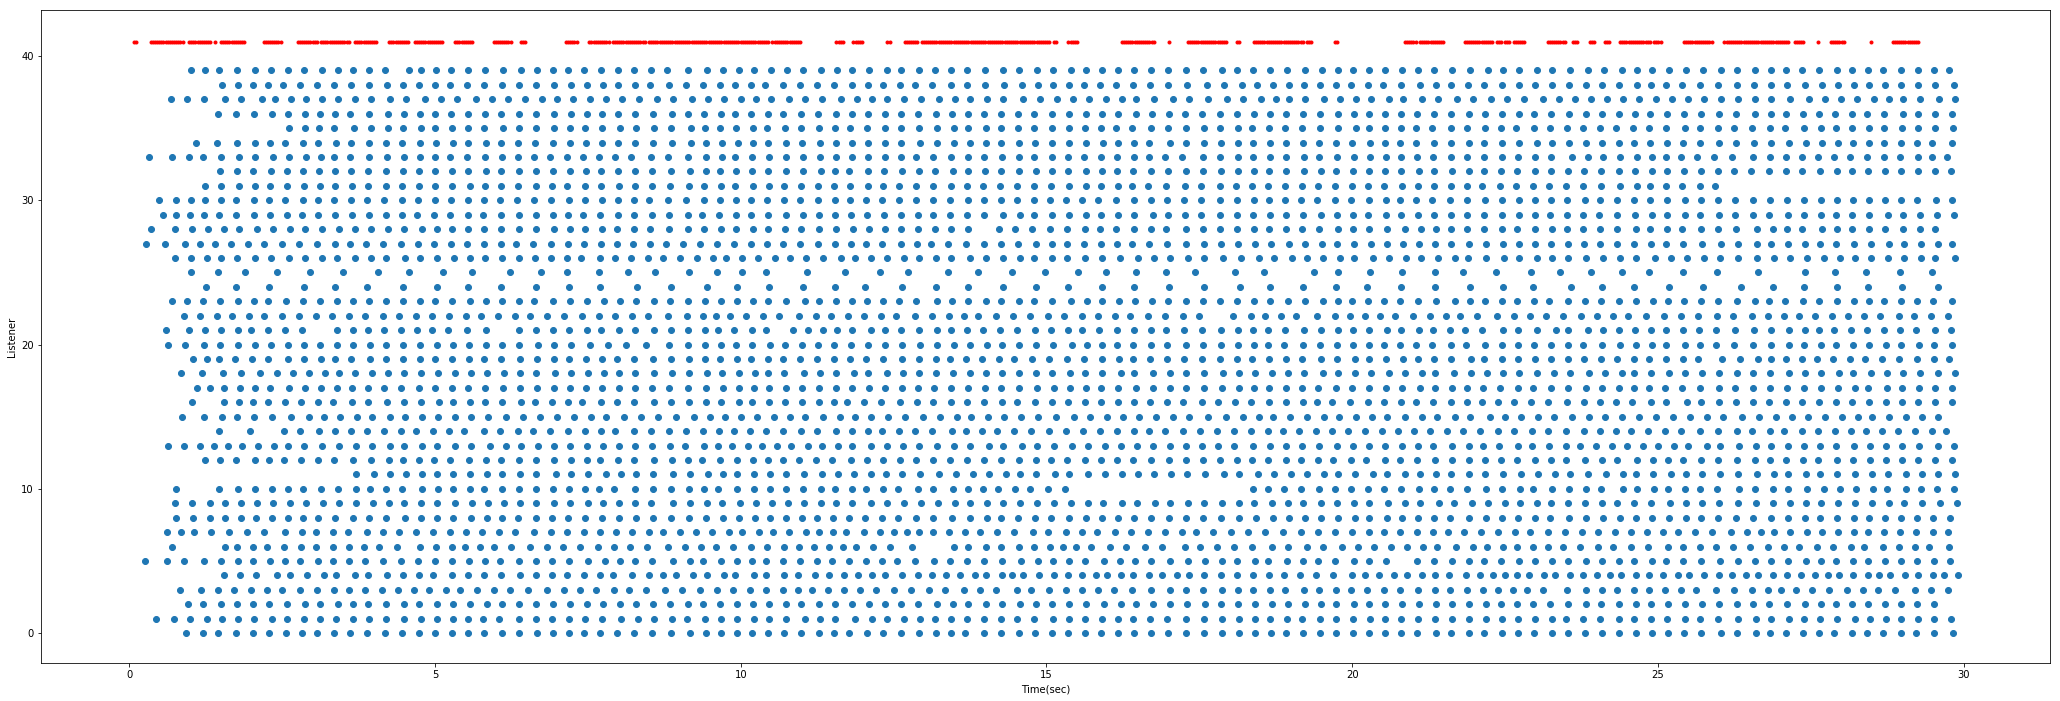

In [7]:
#beat_frames = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
beat_frames = [1 if b > 0.51 else 0 for b in beat_frames]
beat_frame_index = np.nonzero(beat_frames)[0]
frames = range(len(beat_frames))
frame_times = librosa.frames_to_time(frames, sr=fs, hop_length=0.75 * n_fft)
beat_times = [frame_times[bfid] for bfid in beat_frame_index]

gt_beat_times, listeners = get_train_data("./dataset/mirex_beat_tracking_2016/train/%s.txt" % TEST_AUDIO)

y = [41]*len(beat_times)
plt.figure(figsize=[36,12])
plt.scatter(gt_beat_times, listeners)
plt.scatter(beat_times, y, c='r', marker='.')
plt.xlabel('Time(sec)')
plt.ylabel('Listener')
plt.show()

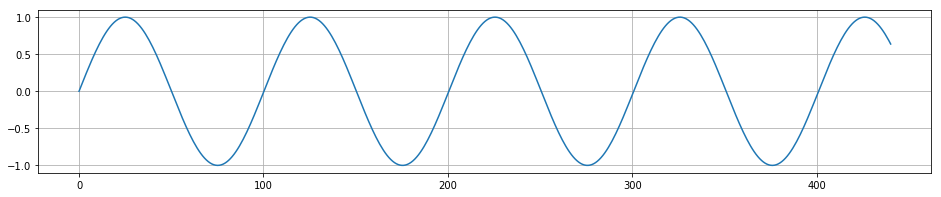

In [8]:
# bee a frame duration
bee_freq = 440 # 440Hz
bee_duration = 0.040 # second
bee_samples = fs * bee_duration
x1 = np.arange(bee_samples)
bee = np.array([np.sin(2*np.pi*bee_freq * (i/fs)) for i in x1])

plt.figure(figsize=[16,3])
plt.plot(x1[:(fs//100)], bee[:(fs//100)]); # show the wave within 100 ms
plt.grid()
ipd.Audio(bee, rate=fs)

In [9]:
audio_raw_data, sr = librosa.load('dataset/mirex_beat_tracking_2016/train/%s.wav' % TEST_AUDIO, sr=fs, mono=True)
listeners, gt_beat_times = np.array(listeners), np.array(gt_beat_times)
beat_times = gt_beat_times[np.where(listeners == 34 )]
print(beat_times.shape)
bee_data = np.zeros(len(audio_raw_data))
for bt in beat_times:
    bee_start = int(bt * fs)
    bee_end = bee_start + len(bee)
    bee_data[bee_start:bee_end] = bee
audio_raw_data = np.add(audio_raw_data, bee_data)

ipd.Audio(audio_raw_data, rate=fs)

(106,)
